타이타닉에 대한 예제는 어느정도 진행했으므로 이번엔 **<Porto Seguro's Safe Driver Prediction>** 에 대해 공부해보려 한다. 먼저 이유한님의 커리큘럼에서 첫 번째 노트북인 **<Data Preparation & Exploration>** 을 보려한다. 이 노트북은 Bert Carremans이 3년 전에 작성하였고, 2021년 1월 12일 기준 *42,118회* 의 조회수와 *366표* 의 투표를 받은 노트북이다.

> https://www.kaggle.com/bertcarremans/data-preparation-exploration

## Introduction

이 노트북은 결과 도출이 목적이 아닌 데이터 모델링을 위한 팁을 제공한다고 생각하면 된다. 노트북의 주요 섹션은 아래와 같다.

1. Visual inspection of your data
2. Defining the metadata
3. Descriptive statistics
4. Handling imbalanced classes
5. Data quality checks
6. Exploratory data visualization
7. Feature engineering
8. Feature selection
9. Feature scaling

## Dataset
### Loading Packages

In [1]:
import pandas as pd # 0.25.1
import numpy as np # 1.18.5
import matplotlib.pyplot as plt # 3.2.2
import seaborn as sns # 0.10.1
# scikit-learn 0.23.1
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100) # 표를 출력할 때 최대 열 수를 설정

### Loading data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Data at first sight

Kaggle 데이터 설명에 대한 발췌:

- 유사한 그룹에 속하는 피쳐는 피쳐 이름(eg. ind, reg, car, calc)에서와 같이 태그가 지정된다.
- bin은 이진 피쳐, cat은 카테고리 피쳐를 의미한다.
- 이러한 이름이 지정되어 있지 않으면 연속형이거나 순서형 피쳐이다.
- -1은 누락된 값이다.
- target 칼럼은 클레임이 접수되었는지의 여부를 나타낸다.

먼저 이 정보들을 알아보기 위해 head를 이용해서 확인해보자.

In [5]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


변수의 특징:

- 이진 변수
- 정수로 되어있는 카테고리형 변수
- 정수형이나 실수형으로된 변수
- -1의 값을 가진 변수
- target과 id

In [6]:
train.shape

(595212, 59)

현재 train 셋에는 59개의 변수와 595212개의 행이 있다. 중복된 행이 있는지 알아보자.

In [7]:
train.drop_duplicates()
train.shape

(595212, 59)

중복된 행은 없는 것으로 보인다.

In [8]:
test.shape

(892816, 58)

test의 변수가 하나 누락된 것을 알 수 있는데 이는 target 변수일 것이다.

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

현재 _cat이 붙은 변수가 14개가 있고, 이를 나중에 더미 변수를 생성해줄 수 있을 것이다. _bin이 붙은 변수는 이미 이진 변수이므로 더미 변수를 생성할 필요는 없다.  
데이터는 49개의 정수형 데이터와 10개의 실수형 데이터로 되어있고, Null 값은 -1로 대체되어 없는 것을 확인할 수 있다.

## Metadata
데이터 관리를 용이하게 하기 위해 변수에 대한 메타 정보를 데이터 프레임에 저장하려한다.

- **role**: input, ID, target
- **level**: nominal, interval, ordinal, binary
- **keep**: True or False
- **dtype**: int, float, str

In [10]:
data = []
for f in train.columns:
    # Defining the role
    if f =='target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'

    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f =='id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
    
    # Defining the data type
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


예를 들어 nominal 데이터를 아래처럼 추출할 수 있다.

In [11]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

role, level에 따른 갯수도 구해볼 수 있다.

In [12]:
pd.DataFrame({'count': meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


## Descriptive Statistics
생성해둔 메타데이터로 기술 통계를 구하기 수월하다.
### Interval Variables

In [16]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


#### reg variables:

- ps_reg_03 만이 결측값을 가지고 있다.
- min~max의 범위가 다른데 이 부분은 이용할 분류기에 따라 스케일링(StandardScaler)이 필요할 것으로 보인다.

#### car variables:

- ps_car_12, ps_car_14 에 결측값이 있다.
- min~max의 범위가 달라 스케일링을 고려해봐야한다.

#### calc variables:
- 결측값이 없다.
- 최댓값이 0.9로 보인다.
- 세 개의 값이 유사한 분포를 보인다.

전체적으로 등간 변수의 범위가 다소 작은데 데이터의 익명화를 위해 변환(log 등)이 이미 적용되었을 수도 있다.

### Ordinal Variables

In [17]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- ps_car_11에서만 결측값이 존재한다.
- 범위가 다른 부분들은 스케일링을 해야한다.

### Binary Variables

In [19]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- train 세트에서 target의 평균은 3.645%로 아주 불균형한 데이터 세트로 보인다.
- 평균값으로 대부분 0의 값을 가지고 있을 것으로 예상할 수 있다.

## Handling Imbalaced Classes
앞서 언급한 것처럼 target이 1인 레코드 비율보다 target이 0인 레코드의 비율이 월등하게 높다. 이렇게하면 예측에 어려움이 있을 수 있으므로, 두 가지 방법 중 한 가지를 적용해서 해결 할 수 있다:

- target = 1 에 대한 오버 샘플링(Oversampling)
- target = 0 에 대한 언더 샘플링(Undersampling)

이 부분의 설명은 예전에 머신러닝 완벽 가이드에서 공부했을 때의 자료를 참고해볼 수 있다. [오버샘플링과 언더샘플링 설명](https://velog.io/@fiifa92/신용카드-사기-검출)  
그 때 언더 샘플링은 *"너무 많은 정상 레이블 데이터를 감소시켜 정상 레이블의 경우 오히려 제대로 된 학습을 할 수 없다는 단점이 있어 잘 적용하지 않는다."* 라고 했는데 여기선 언더 샘플링을 적용한다.

In [20]:
desired_apriori = 0.10

# target의 인덱스 추출
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# target당 갯수 추출
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# 언더샘플링 비율 및 target=0의 갯수 계산
undersampling_rate = ((1-desired_apriori) * nb_1)/(nb_0 * desired_apriori)
undersampled_nb_0 = int(undersampling_rate * nb_0)
print(f'Rate to undersample records with target=0: {undersampling_rate}')
print(f'Number of records with target=0 after undersampling: {undersampled_nb_0}')

# 랜덤으로 target=0인 값 추출
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# 리스트 재생성
idx_list = list(undersampled_idx) + list(idx_1)

# 언더샘플링된 데이터 프레임 리턴
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


## Data Quality Checks
### Checking missing values
-1인 값은 결측값을 의미한다.

In [26]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        print(f'변수 {f} 는 {missings} 개의 결측값을 가지고 있으며, 퍼센트는 {missings_perc:.2%} 이다.')

print(f'전체 결측값 칼럼 갯수: {len(vars_with_missing)}')

변수 ps_ind_02_cat 는 103 개의 결측값을 가지고 있으며, 퍼센트는 0.05% 이다.
변수 ps_ind_04_cat 는 51 개의 결측값을 가지고 있으며, 퍼센트는 0.02% 이다.
변수 ps_ind_05_cat 는 2256 개의 결측값을 가지고 있으며, 퍼센트는 1.04% 이다.
변수 ps_reg_03 는 38580 개의 결측값을 가지고 있으며, 퍼센트는 17.78% 이다.
변수 ps_car_01_cat 는 62 개의 결측값을 가지고 있으며, 퍼센트는 0.03% 이다.
변수 ps_car_02_cat 는 2 개의 결측값을 가지고 있으며, 퍼센트는 0.00% 이다.
변수 ps_car_03_cat 는 148367 개의 결측값을 가지고 있으며, 퍼센트는 68.39% 이다.
변수 ps_car_05_cat 는 96026 개의 결측값을 가지고 있으며, 퍼센트는 44.26% 이다.
변수 ps_car_07_cat 는 4431 개의 결측값을 가지고 있으며, 퍼센트는 2.04% 이다.
변수 ps_car_09_cat 는 230 개의 결측값을 가지고 있으며, 퍼센트는 0.11% 이다.
변수 ps_car_11 는 1 개의 결측값을 가지고 있으며, 퍼센트는 0.00% 이다.
변수 ps_car_14 는 15726 개의 결측값을 가지고 있으며, 퍼센트는 7.25% 이다.
전체 결측값 칼럼 갯수: 12


- ps_car_03_cat 과 ps_car_05_cat은 너무 높은 비중의 결측값이 있으므로 제거한다.
- 카테고리형 변수의 결측값은 -1로 남겨둔다.
- ps_reg_03(countinuous)는 약 18%의 결측값이 있으므로 평균으로 대체한다.
- ps_car_11(ordinal)은 1개의 결측값을 가지고 있으므로 최빈값으로 대체한다.
- ps_car_14(countinuous)는 약 7%의 결측값이 있으므로 평균으로 대체한다.

In [27]:
# 너무 높은 비중의 결측값이 있는 데이터 제거
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)

# 메타데이터 업데이트
meta.loc[(vars_to_drop), 'keep'] = False 

# 평균, 최빈값으로 대체
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

### Checking the cardinality of the categorical variables
카테고리형 변수로 더미 변수를 생성하기 전에 각 카테고리 변수에 몇 개의 값들이 있는지 알아보자.

In [29]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print(f'변수 {f} 는 {dist_values} 개의 값을 가지고 있다.')

변수 ps_ind_02_cat 는 5 개의 값을 가지고 있다.
변수 ps_ind_04_cat 는 3 개의 값을 가지고 있다.
변수 ps_ind_05_cat 는 8 개의 값을 가지고 있다.
변수 ps_car_01_cat 는 13 개의 값을 가지고 있다.
변수 ps_car_02_cat 는 3 개의 값을 가지고 있다.
변수 ps_car_04_cat 는 10 개의 값을 가지고 있다.
변수 ps_car_06_cat 는 18 개의 값을 가지고 있다.
변수 ps_car_07_cat 는 3 개의 값을 가지고 있다.
변수 ps_car_08_cat 는 2 개의 값을 가지고 있다.
변수 ps_car_09_cat 는 6 개의 값을 가지고 있다.
변수 ps_car_10_cat 는 3 개의 값을 가지고 있다.
변수 ps_car_11_cat 는 104 개의 값을 가지고 있다.


ps_car_11_cat이 많은 값을 가지고 있다. 여기서 필자는 [oliver](https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features) 이 만든 커널을 적용한다.

In [30]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, tst_series=None, target=None, min_samples_leaf=1, smoothing=1, noise_level=0):
    '''
    trn_series: train의 카테고리 피쳐(pd.Series)
    tst_series: test의 카테고리 피쳐(pd.Series)
    target: target 데이터(pd.Series)
    min_samples_leaf(int): 카테고리 평균을 고려할 최소 샘플 수
    smoothing(int): 범주형 평균과 이전의 평균의 균형을 유지하는 평활 효과
    '''
    # assert: 가정설정문, 어떤 조건을 테스트하는 디버깅 보조 도구
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # target 평균 계산
    averages = temp.groupby(by=trn_series.name)[target.name].agg(['mean', 'count'])
    # smoothing 계산
    smoothing = 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))
    # 모든 target에 평균 적용
    prior = target.mean()
    # count가 클수록 full_avg가 적게 고려된다.
    averages[target.name] = prior * (1 - smoothing) + averages['mean'] * smoothing
    averages.drop(['mean', 'count'], axis=1, inplace=True)
    # trn에 평균 적용 및 인덱스 복구
    ft_trn_series = pd.merge(trn_series.to_frame(trn_series.name),
                            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
                            on=trn_series.name,
                            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    ft_trn_series.index = trn_series.index
    # tst에 평균 적용 및 인덱스 복구
    ft_tst_series = pd.merge(tst_series.to_frame(tst_series.name),
                            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
                            on=tst_series.name,
                            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    ft_tst_series.index = tst_series.index
    
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [31]:
train_encoded, test_encoded = target_encode(train['ps_car_11_cat'], 
                                            test['ps_car_11_cat'],
                                            target=train.target, 
                                            min_samples_leaf=100,
                                            smoothing=10,
                                            noise_level=0.01)
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat', 'keep'] = False
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

## Exploratory Data Visualization
### Categorical Variables
카테고리형 변수와 target이 1인 고객의 분포를 확인해보자.

<Figure size 432x288 with 0 Axes>

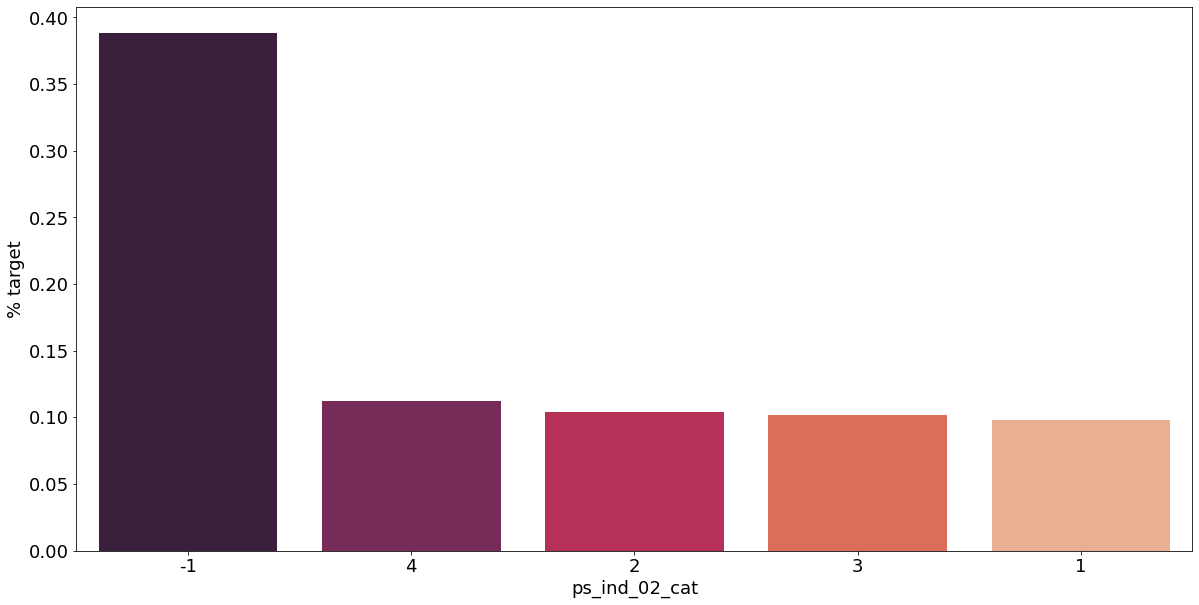

<Figure size 432x288 with 0 Axes>

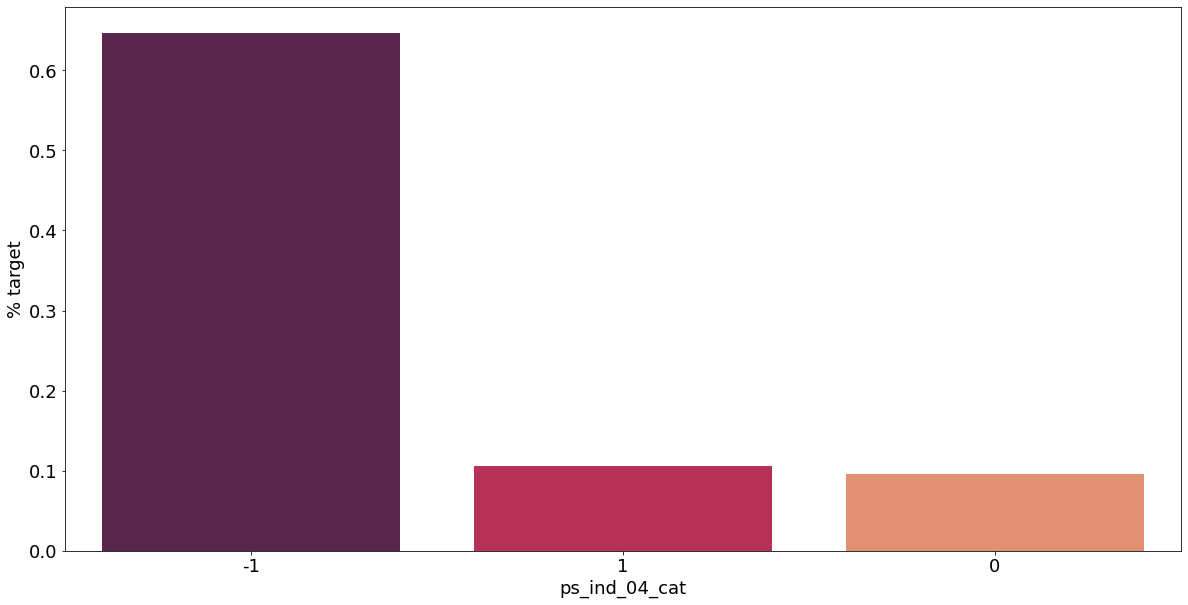

<Figure size 432x288 with 0 Axes>

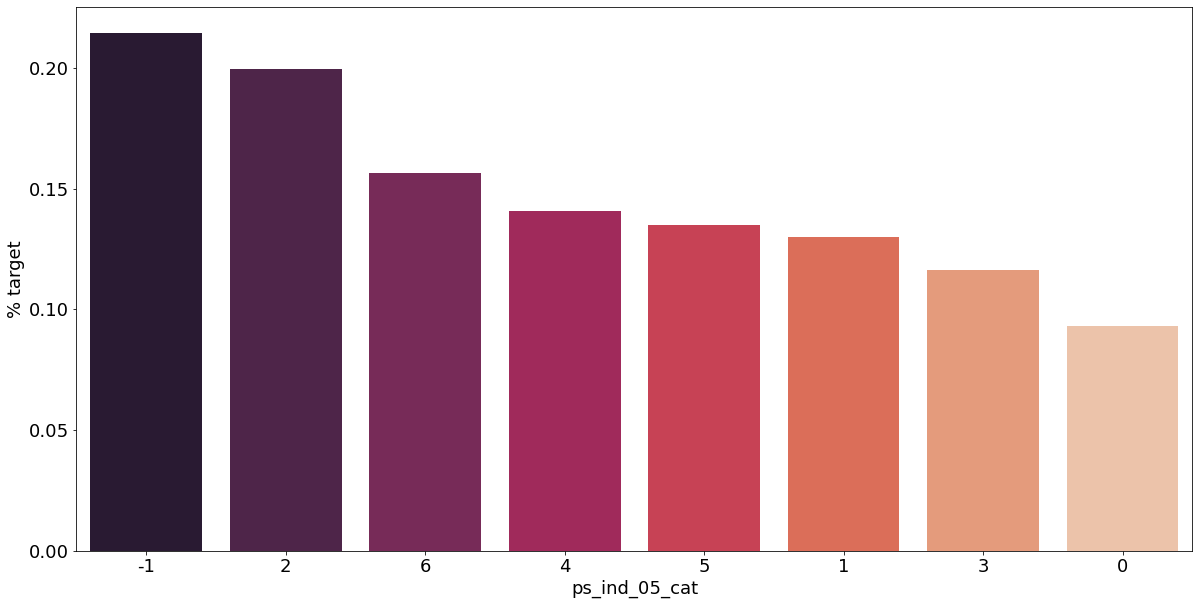

<Figure size 432x288 with 0 Axes>

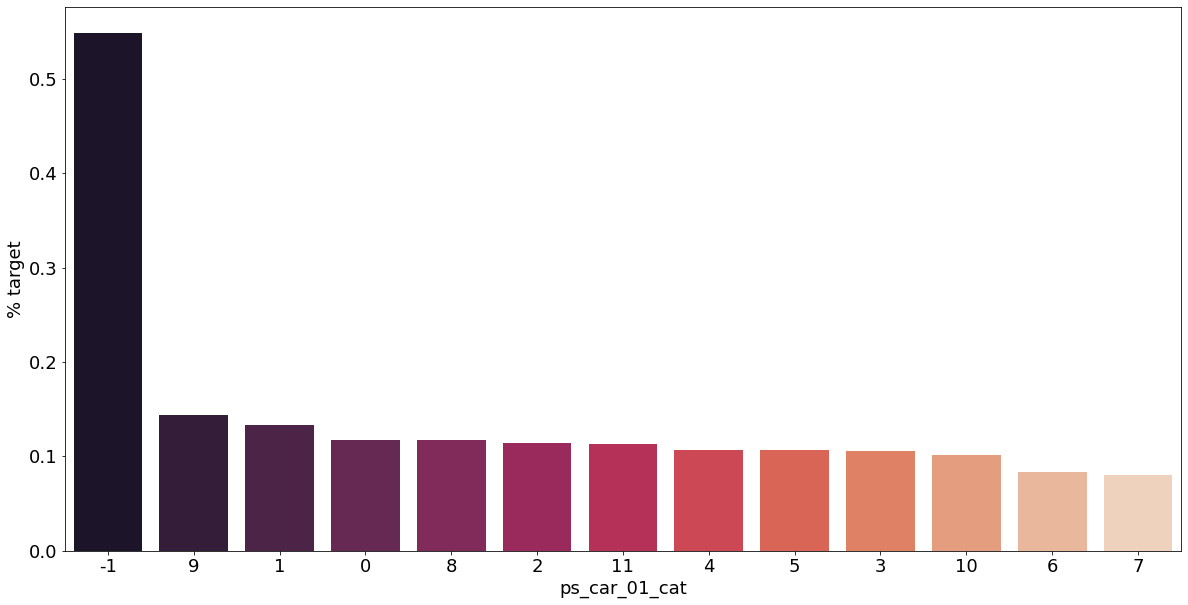

<Figure size 432x288 with 0 Axes>

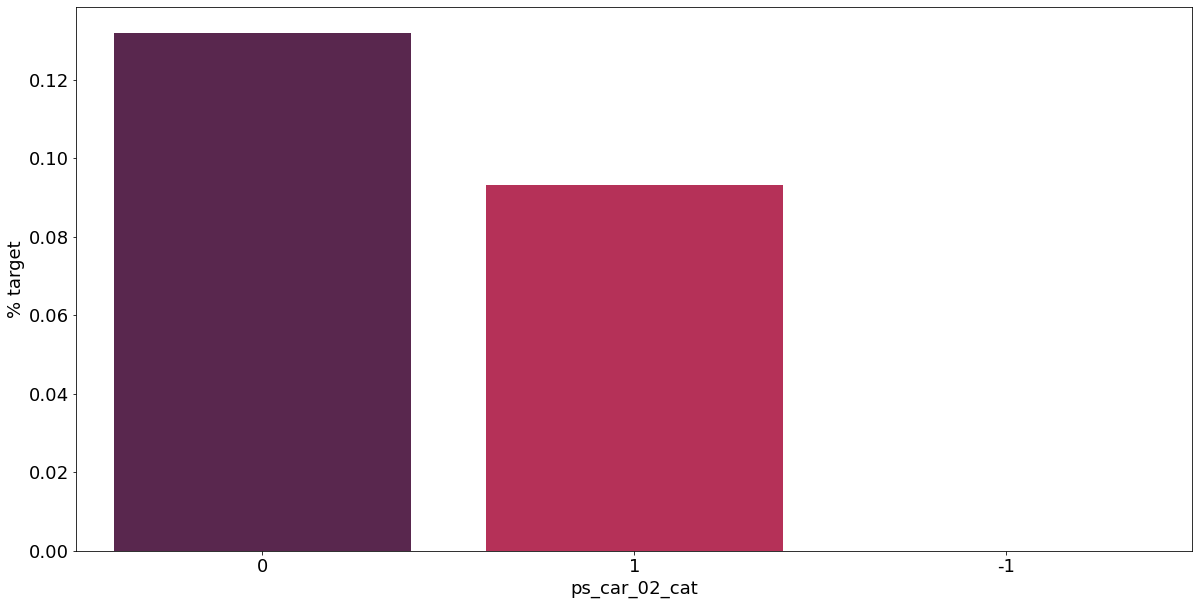

<Figure size 432x288 with 0 Axes>

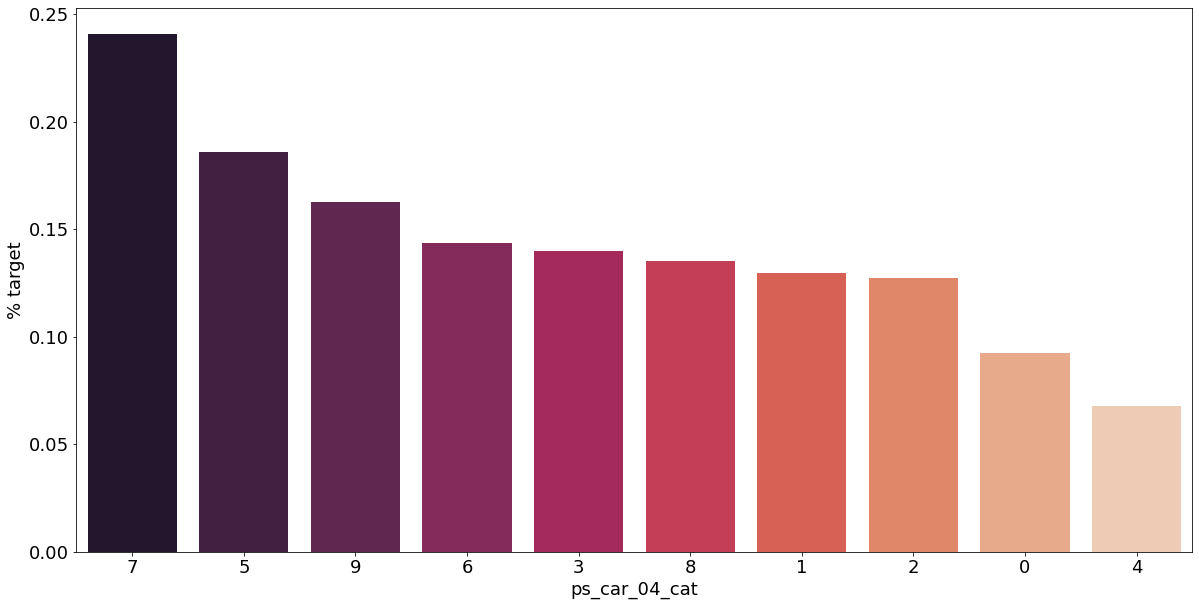

<Figure size 432x288 with 0 Axes>

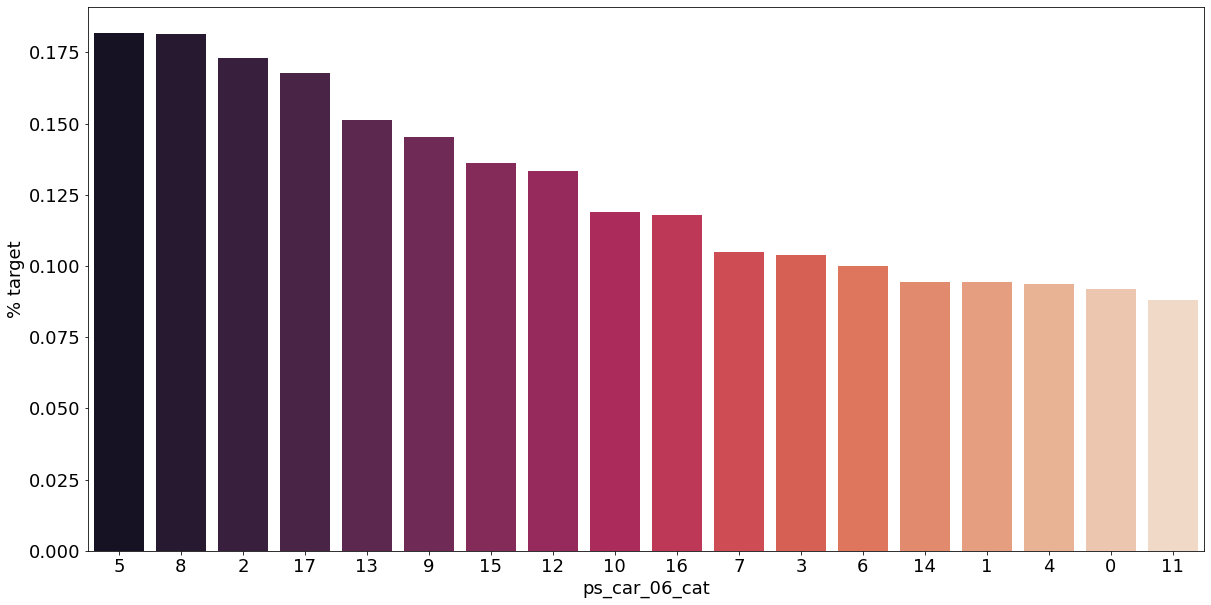

<Figure size 432x288 with 0 Axes>

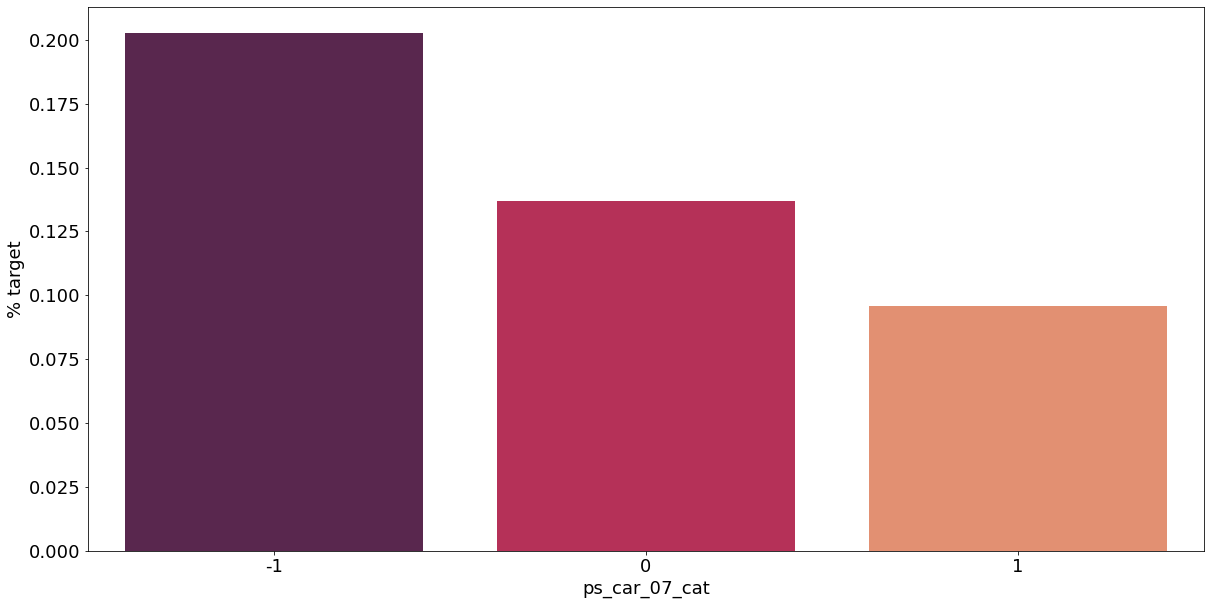

<Figure size 432x288 with 0 Axes>

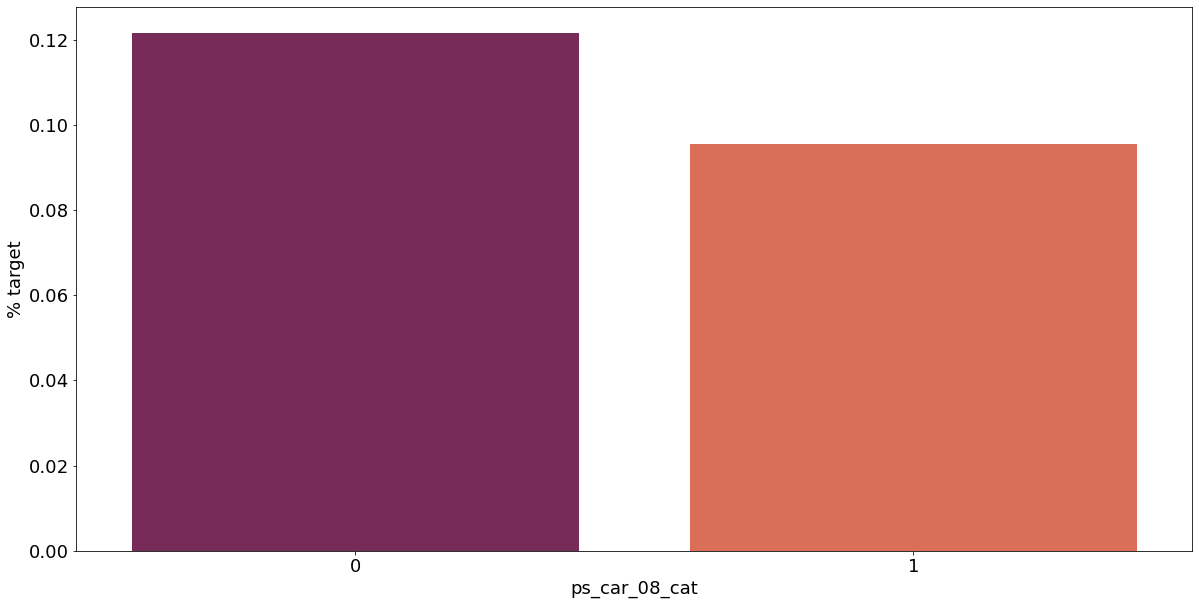

<Figure size 432x288 with 0 Axes>

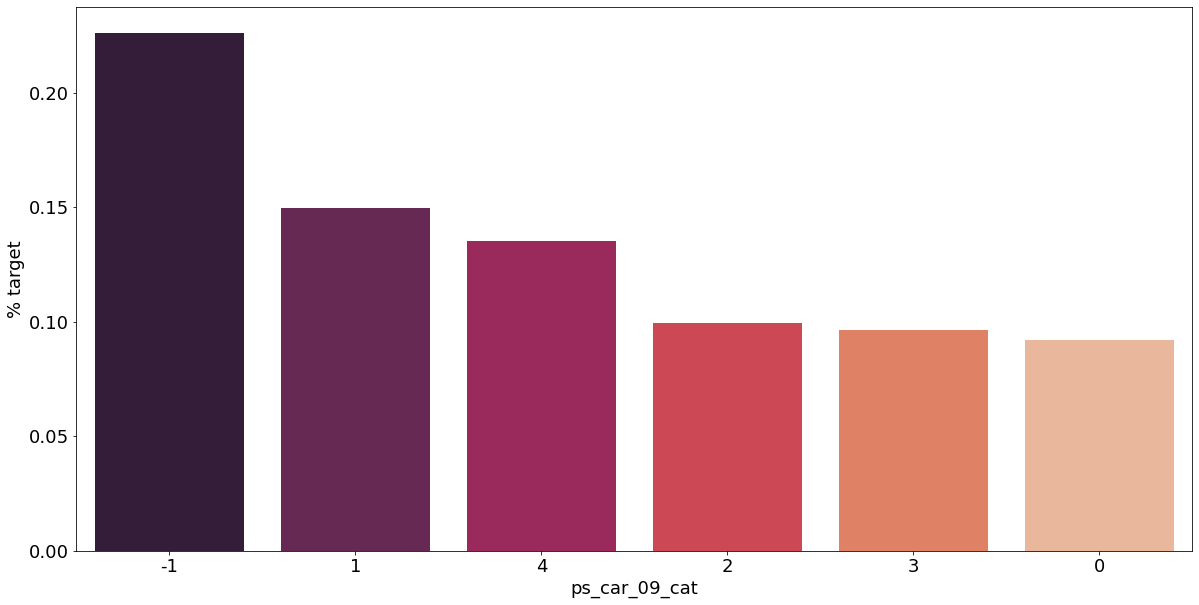

<Figure size 432x288 with 0 Axes>

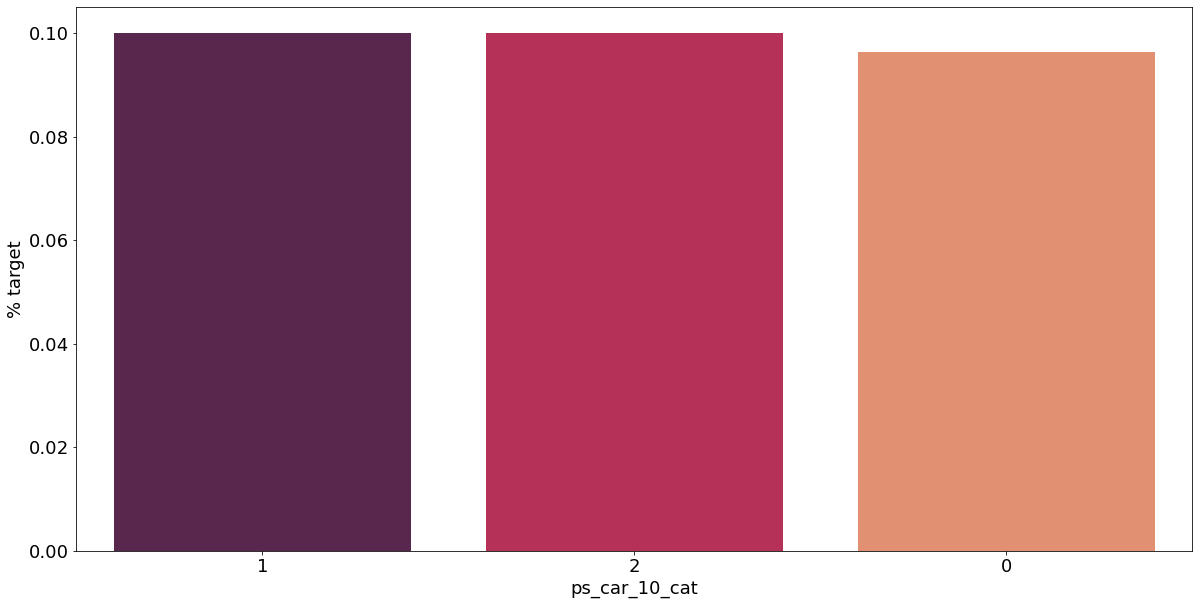

In [34]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20, 10))
    cat_perc = train[[f, 'target']].groupby([f], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f], palette='rocket')
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)

결측값이 있는 고객은 보험 청구를 요청할 확률이 훨씬 높은 것으로 보인다.(낮은 경우도 있음) 이를 최빈값으로 교체하는 등 방법이 다양하게 있을 것이다.  

### Interval Variables
간격 변수들의 상관 관계를 알아보자. 아래 코드는 [an example by Michael Waskom](http://seaborn.pydata.org/examples/many_pairwise_correlations.html)에 기반하여 작성하였다.

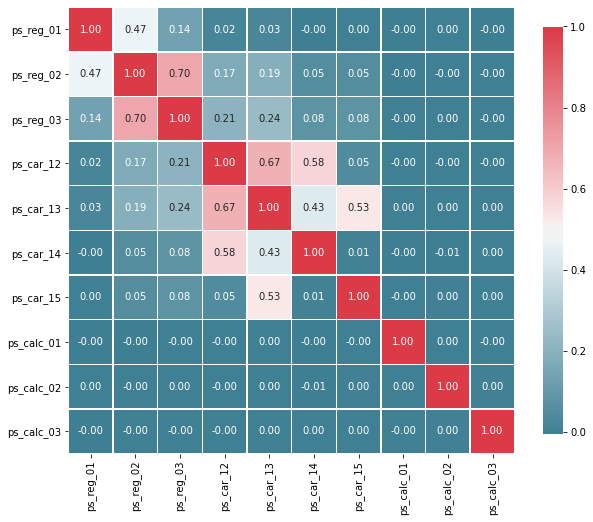

In [35]:
def corr_heatmap(v):
    correlations = train[v].corr()
    
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={'shrink': .75})
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

높은 상관관계를 가진 변수들:

- ps_reg_02 와 ps_reg_03 (0.70)
- ps_car_12 와 ps_car_13 (0.67)
- ps_car_12 와 ps_car_14 (0.58)
- ps_car_13 과 ps_car_15 (0.53)

In [36]:
# 빠른 프로세싱을 위해 샘플 추출
s = train.sample(frac=0.1)

#### ps_reg_02 and ps_reg_03
아래 회귀 직선을 확인하면 피쳐들이 선형 관계가 있다는 것을 알 수 있고, *hue* 로 회귀 직선이 target=0 일 때와 1일 때를 볼 수 있다.

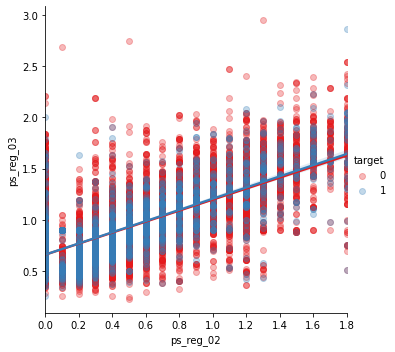

In [37]:
sns.lmplot('ps_reg_02', 'ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha': 0.3})

#### ps_car_12 and ps_car_13

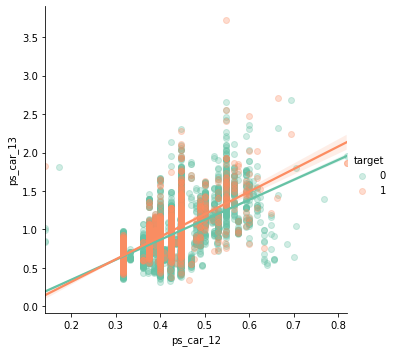

In [39]:
sns.lmplot('ps_car_12', 'ps_car_13', data=s, hue='target', palette='Set2', scatter_kws={'alpha': 0.3})

#### ps_car_12 and ps_car_14

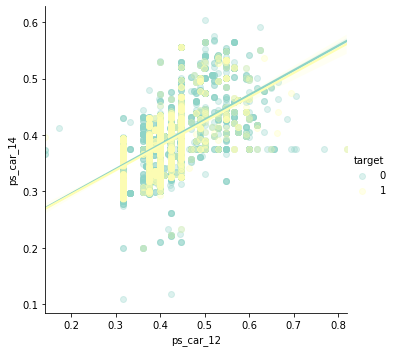

In [40]:
sns.lmplot('ps_car_12', 'ps_car_14', data=s, hue='target', palette='Set3', scatter_kws={'alpha': 0.3})

#### ps_car_13 and ps_car_15

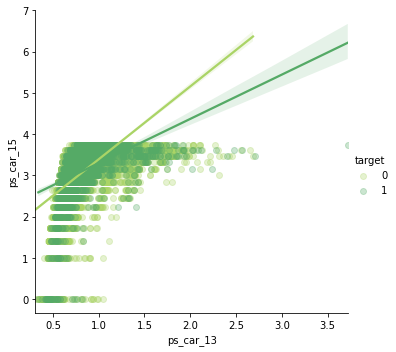

In [42]:
sns.lmplot('ps_car_13', 'ps_car_15', data=s, hue='target', palette='summer_r', scatter_kws={'alpha': 0.3})

그래프 형태가 더 눈에 띌 수 있게 x, y 축 값을 바꾸자.

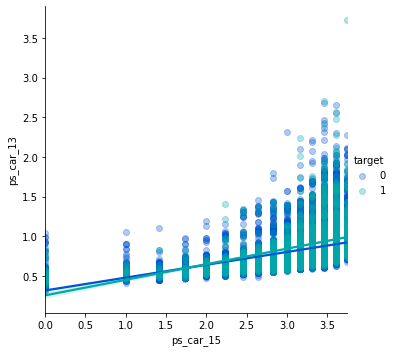

In [43]:
sns.lmplot('ps_car_15', 'ps_car_13', data=s, hue='target', palette='winter', scatter_kws={'alpha': 0.3})

### Checking the Correlations between Ordinal Variables

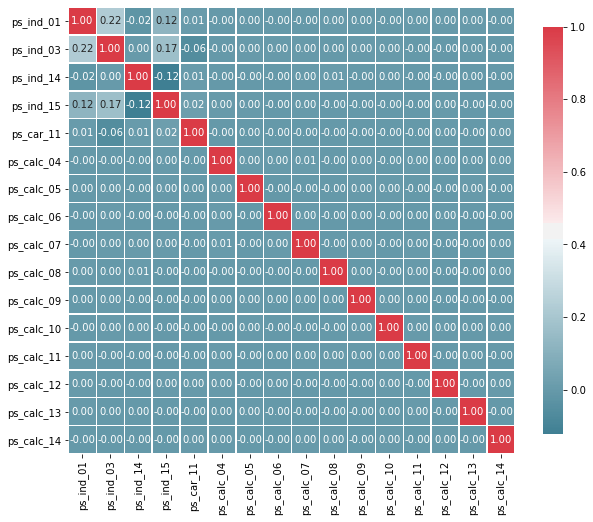

In [44]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

서수형 변수들에선 상관관계가 높게 나타나지 않는다. 하지만 우리는 목표값별로 그룹화할 때 분포가 어떻게 되는지 알아볼 수 있다.

## Feature Engineering
### Creating Dummy Variables
카테고리형 변수에서 1과 2는 값이 두 배임을 의미하진 않는다. 그러므로 더미형 변수를 만들어줘야 한다. 첫 번째 더미 변수를 삭제하는 이유는 원래 변수의 범주에 대해 생성된 다른 더미 변수에서 파생될 수 있기 때문이다.

In [45]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print(f'더미화 전에 train 세트에 있는 변수의 갯수: {train.shape[1]}')
train = pd.get_dummies(train, columns=v, drop_first=True)
print(f'더미화 후에 train 세트에 있는 변수의 갯수: {train.shape[1]}')

더미화 전에 train 세트에 있는 변수의 갯수: 57
더미화 후에 train 세트에 있는 변수의 갯수: 109


52개의 더미 변수가 추가되었다.  

drop_first에 대한 추가 설명: 타이타닉 예제에서 예를 들면 Pclass가 1, 2, 3이 있었고, 이에 더미 변수를 생성하면 Pclass_1, Pclass_2, Pclass_3이 나온다. 여기서 `drop_first` 를 하면 Pclass_2, Pclass_3 만 나온다. 이렇게해도 두 값이 0이라면 Pclass가 1임을 알 수 있기 때문이다.

### Creating interaction variables

PolynomialFeatures함수는 데이터를 다항식 형태로 변경한다. 
- degree: 차수를 조절
- include_bias: True로 할 경우 0차항(1)도 만듦.
- interaction_only: 교호작용을 할 변수만 만들지 여부를 결정.

In [47]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)
print(f'교호작용 전에 train 세트에 있는 변수의 갯수: {train.shape[1]}')
train = pd.concat([train, interactions], axis=1)
print(f'교호작용 후에 train 세트에 있는 변수의 갯수: {train.shape[1]}')

교호작용 전에 train 세트에 있는 변수의 갯수: 109
교호작용 후에 train 세트에 있는 변수의 갯수: 164


55개의 교호작용 변수가 추가되었다.

## Feature Selection
### Removing Features with low or zero variance
분산이 없거나 매우 낮은 피쳐를 제거할 수 있는데, sklearn의 **VarianceThreshold** 를 이용해서 제거할 수 있다. 기본적으로는 분산이 0인 피쳐를 제거하는데 이전 단계에서 분산이 0인 변수가 없었으므로, 1%미만인 피쳐를 제거하게 설정할 수 있다.  

Vectorize는 매트릭스 구조의 데이터의 연산을 일괄적으로 처리할 수 있도록 Series, DataFrame, array 등과 같이 시퀀스형 자료를 함수의 매개변수로 포함시킬 수 있게 하는 것을 말한다.

In [48]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(train.drop(['id', 'target'], axis=1))
f = np.vectorize(lambda x: not x)
v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())] # get_support()는 선택된 특성을 boolean 값으로 표시해 어떤 특성이 선택되었는지 확인 가능
print(f'{len(v)} 개의 변수가 너무 낮은 분산을 갖고 있다.')
print(f'변수 리스트:\n{list(v)}')

28 개의 변수가 너무 낮은 분산을 갖고 있다.
변수 리스트:
['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


만약 분산을 바탕으로 선택을 하면 많은 변수가 없어질 수 있다. 그러나 우리가 지금 변수를 많이 갖고있기에 분류기가 선택하도록 하자. sklearn의 **SelectFromModel** 메서드를 사용하면 최상의 피쳐를 선택하게 할 수 있다. 아래에서 랜덤 포레스트를 통해 방법을 설명한다.

### Selecting Features with a Random Forest and SelectFromModel

랜덤 포레스트의 **feature importances** 를 이용해서 선택하도록 하자. **SelectFromModel** 로 유지할 변수의 수를 지정할 수 있고, feature importances에 대한 임곗값을 수동으로 설정할 수 있다. 여기선 간단하게 상위 50%만을 설정한다.  

이 코드는 [GitHub repo of Sebastian Raschka](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch04/ch04.ipynb) 에서 참고했다.

In [49]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.021010
 2) ps_car_13                      0.017335
 3) ps_car_13^2                    0.017320
 4) ps_car_12 ps_car_13            0.017257
 5) ps_car_13 ps_car_14            0.017169
 6) ps_reg_03 ps_car_13            0.017106
 7) ps_reg_01 ps_car_13            0.016905
 8) ps_car_13 ps_car_15            0.016836
 9) ps_reg_03 ps_car_14            0.016238
10) ps_reg_03 ps_car_12            0.015469
11) ps_reg_03 ps_car_15            0.015133
12) ps_car_14 ps_car_15            0.015055
13) ps_car_13 ps_calc_02           0.014721
14) ps_car_13 ps_calc_01           0.014721
15) ps_reg_02 ps_car_13            0.014694
16) ps_reg_01 ps_reg_03            0.014691
17) ps_car_13 ps_calc_03           0.014675
18) ps_reg_01 ps_car_14            0.014328
19) ps_reg_03^2                    0.014262
20) ps_reg_03                      0.014198
21) ps_reg_03 ps_calc_02           0.013798
22) ps_reg_03 ps_calc_03           0.013758
23) ps_reg_03 ps_calc_01        

In [50]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print(f'Selection 전 피쳐의 수: {X_train.shape[1]}')
n_features = sfm.transform(X_train).shape[1]
print(f'Selection 후 피쳐의 수: {n_features}')
selected_vars = list(feat_labels[sfm.get_support()])

Selection 전 피쳐의 수: 162
Selection 후 피쳐의 수: 81


In [51]:
train = train[selected_vars + ['target']]

## Feature Scaling
앞서 언급한 것과 같이 train 세트에 standard scaling을 할 수 있고, 이는 몇몇 분류기의 성능을 향상시킬 수 있다.

In [52]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.05087653, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356,  1.61399304, ...,  0.28148164,
        -0.11358706, -0.72653353]])